# Recommender tutorial

This is one of my [favorite tutorials](https://www.datacamp.com/community/tutorials/recommender-systems-python?utm_source=adwords_ppc&utm_campaignid=1565261270&utm_adgroupid=67750485268&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=1t1&utm_creative=295208661502&utm_targetid=aud-299261629574:dsa-473406569915&utm_loc_interest_ms=&utm_loc_physical_ms=9060221&gclid=CjwKCAiAs8XiBRAGEiwAFyQ-eoey7NqtxrCNAAVnfiHOBNR1mzU99cuJKnKFkEPcnnJsRVvp3u1xMRoCBM4QAvD_BwE) for recommenders using NLP and text analytics.  Suggested by Joanne.


In [1]:
import pandas as pd

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer # if not downweighting across docs

from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity # use with CountVectorizer

from ast import literal_eval

import numpy as np

In [2]:
infile = '../data/the-movies-dataset/movies_metadata.csv'
metadata = pd.read_csv(infile, low_memory=False)
metadata.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0



### Simple recommender
Weighted Ratings

No right value for m.  Use it as a preliminary negative filter that ignores movies w/ less than a certain number of votes.

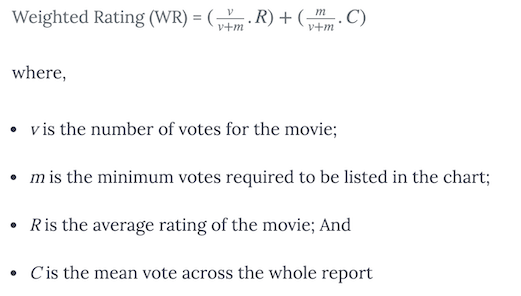

In [3]:
# Calculate C:
C = metadata['vote_average'].mean()
print(C)

# calculate m, the min. number of votes required to be in the chart (based arbitrarily on 90th percentile)
m = metadata['vote_count'].quantile(0.90)
print(m)

# Qualified movies
q_movies = metadata.copy().loc[metadata['vote_count'] >= m]
print(q_movies.shape)

# Compute weighted rating of each movie
def weighted_rating(row, m=m, C=C):
    v = row['vote_count']
    R = row['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

# create new 'score' feature
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

q_movies = q_movies.sort_values('score', ascending=False)
q_movies[['title','vote_count','vote_average','score']].head(15)

5.618207215134185
160.0
(4555, 24)


,title,vote_count,vote_average,score
314,The Shawshank Redemption,8358.0,8.5,8.445869
834,The Godfather,6024.0,8.5,8.425439
10309,Dilwale Dulhania Le Jayenge,661.0,9.1,8.421453
12481,The Dark Knight,12269.0,8.3,8.265477
2843,Fight Club,9678.0,8.3,8.256385
292,Pulp Fiction,8670.0,8.3,8.251406
522,Schindler's List,4436.0,8.3,8.206639
23673,Whiplash,4376.0,8.3,8.205404
5481,Spirited Away,3968.0,8.3,8.196055
2211,Life Is Beautiful,3643.0,8.3,8.187171


### Content-based recommender
Recommend movies that are similar to a particular movie:  compute pairwise similarity scores for all movies based on that similarity score.


Compute word vectors for each overview (document)compute TF-IDF vectors for each document, to get a matrix where each column represents a word in the overview vocabulary (all the words appearing in at least one document), and each column represents a movie.

TF-IDF score isthe frequency of a word occurring in a document, down-weighted by the number of documents in which it occurs.  Reduce the importance of words that occur frequently in plot overviews.

With the tfidf_matrix I'll compute a similarity score (several methods: euclidean, pearson, cosine, etc.).  We'll do cosine use cosine similarity (magnitude independent, fast, and easy) to calculate a numeric quantity that denotes the similarity between 2 movies.  

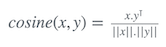


In [4]:
print(metadata['overview'].head())

# define a tf-idf vectorizer object.  Remove all english stopwords (a, the, ...)
tfidf = TfidfVectorizer(stop_words='english')

text.ENGLISH_STOP_WORDS # list of 318 words to remove

# replace NaN with empty string
metadata['overview'] = metadata['overview'].fillna('')

# construct the required tf-idf matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(metadata['overview'])
print(tfidf_matrix.shape) #>75k words, >45k movies

# since I used the tf-idf vectorizer, calculating the dot product 
# will directly give the cosine similarity score.  Therefore we'll 
# use sklearn's linear_kernel() instead of cosine_similarities() 
# since it is faster.

# compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)


0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
3    Cheated on, mistreated and stepped on, the wom...
4    Just when George Banks has recovered from his ...
Name: overview, dtype: object
(45466, 75827)


In [5]:
print(type(cosine_sim), cosine_sim.shape)
print(cosine_sim[:5,:5])

<class 'numpy.ndarray'> (45466, 45466)
[[1.         0.01504121 0.         0.         0.        ]
 [0.01504121 1.         0.04681953 0.         0.        ]
 [0.         0.04681953 1.         0.         0.02509444]
 [0.         0.         0.         1.         0.        ]
 [0.         0.         0.02509444 0.         1.        ]]


##### Recommend 10 most similar movies
Define a function that takes in a movie title as an input and returns a list of the 10 most similar movies.  First I need a reverse mapping of movie titles and df indices (a mechanism to identify the index of a movie in my metadata df, given its title).

Then I'll define my recommendation function using these steps:
1. get the index of the movie, given its title
1. get the list of cosine similarity scores for that particular movie with all movies.  convert it into a list of tuples, where the first element is its position and the second is the similarity score.
1. sort this list of tuples based on the similarity of scores.
1. get the top 10 elements of this list (ignoring the first, self-referencing element).
1. return the titles corresponding to the indices of the top elements.

In [6]:
# construct a reverse map of indices and movie titles
indices = pd.Series(metadata.index, index=metadata['title']).drop_duplicates()

def get_recommendations(title, cosine_sim=cosine_sim):
    '''takes in movie title and returns most similar movies'''
    
    # get index of the movie that matches the title
    idx = indices[title]
    
    # get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx])) #linear_kernal, above
    
    # sort based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # get the scores of 10 most similar movies
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return metadata['title'].iloc[movie_indices]

print(get_recommendations('The Dark Knight Rises'))
print(get_recommendations('The Godfather'))
#print(get_recommendations('Anchorman: The Legend of Ron Burgundy'))



12481                                      The Dark Knight
150                                         Batman Forever
1328                                        Batman Returns
15511                           Batman: Under the Red Hood
585                                                 Batman
21194    Batman Unmasked: The Psychology of the Dark Kn...
9230                    Batman Beyond: Return of the Joker
18035                                     Batman: Year One
19792              Batman: The Dark Knight Returns, Part 1
3095                          Batman: Mask of the Phantasm
Name: title, dtype: object
1178               The Godfather: Part II
44030    The Godfather Trilogy: 1972-1990
1914              The Godfather: Part III
23126                          Blood Ties
11297                    Household Saints
34717                   Start Liquidation
10821                            Election
38030            A Mother Should Be Loved
17729                   Short Sharp Shock
26293

### Recommender using credits, genres, and keywords

Load in additional metadata, and build recommender based on top 3 actors, director, related genres and movie plot keywords.

##### The following should only be run once, alters the df.  If needing to make changes, rerun the whole notebook.  The cell below takes a minute to run.

In [7]:
%%time
# Load keywords and credits
credits = pd.read_csv('../data/the-movies-dataset/credits.csv')
keywords = pd.read_csv('../data/the-movies-dataset/keywords.csv')

# Remove rows with bad IDs
try:
    metadata = metadata.drop([19730, 29503, 35587])
except:
    pass

# convert IDs to int for merging
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
metadata['id'] = metadata['id'].astype('int')

# merge keywords and credits into main metadata df
metadata = metadata.merge(credits, on='id')
metadata = metadata.merge(keywords, on='id')

metadata.head(2)

# convert actors, director, keywords from stringified lists to usable form.
# parse stringified features into their corresponding python objects

features = ['cast','crew','keywords','genres']
for feature in features:
    metadata[feature] = metadata[feature].apply(literal_eval)
    
# get director's name from crew feature, else return NaN if not defined
def get_director(row):
    for i in row:
        if i['job'] == 'Director':
            return i['name']
        return np.nan
    
# return the list of top 3 elements or entire list, whichever is more don't think this is right
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        if len(names) > 3:
            names = names[:3]
        return names
    
    # return empty list in case of missing/malformed data
    return []


# define new features: director, cast, genres, keywords
metadata['director'] = metadata['crew'].apply(get_director)

features = ['cast','crew','keywords','genres']
for feature in features:
    metadata[feature] = metadata[feature].apply(get_list)
    
metadata[['title','cast','crew','keywords','genres']].head(3)

CPU times: user 44.9 s, sys: 937 ms, total: 45.8 s
Wall time: 46 s


Phew!

### Metadata Soup and Cosine Similarity
Next steps are 
* convert the names and keyword instances into lowercase, and strip all the spaces between them.  This is so that my vectorizer doesn't count the Johnny of "Johnny Depp" and "Johnny Galecki" as the same.  after this processing step, the actors will be represented as "johnnydepp" and "johnnygalecki" and will be distinct to my vectorizer.

After this I'll be in position to create a 'metadata soup', a string that contains all the metadata I want to feed to my vectorizer (namely actors, directors, and keywords).

In [8]:
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(' ', '')) for i in x]
    else:
        if isinstance(x, str):
            return str.lower(x.replace(' ',''))
        else:
            return ''

features = ['cast','keywords','director','genres']

for feature in features:
    metadata[feature] = metadata[feature].apply(clean_data)

def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])     

metadata['soup'] = metadata.apply(create_soup, axis=1)



In [9]:
metadata['soup'][0]

'jealousy toy boy tomhanks timallen donrickles johnlasseter animation comedy family'

Next steps are similar to the plot description based recommender, except I'll use `CountVectorizer()` instead of `TF-IDF`.  _We don't want to down-weight the presence of an actor/director if they have acted or directed in relatively more movies._ 

In [10]:
# create the count matrix
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(metadata['soup'])

# compute Cosine Similarity matrix based on count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

# reset index of main dataframe and construct reverse mapping as before
metadata = metadata.reset_index()
indices = pd.Series(metadata.index, index = metadata['title'])

# Reuse my `get_recommendations()` fctn, passing in cosine_sim2 as 2nd arg
get_recommendations('The Dark Knight Rises', cosine_sim=cosine_sim2)
get_recommendations('The Godfather', cosine_sim2)

1934            The Godfather: Part III
8001     The Night of the Following Day
18261                 The Son of No One
39193                 The Good Neighbor
18940                         Last Exit
34488                              Rege
35802            Manuscripts Don't Burn
35803            Manuscripts Don't Burn
28683            In the Name of the Law
7772                           Mitchell
Name: title, dtype: object

There are, of course, numerous ways of playing with this system in order to improve recommendations.

Some suggestions:

* Introduce a popularity filter: this recommender would take the list of the 30 most similar movies, calculate the weighted ratings (using the IMDB formula from above), sort movies based on this rating and return the top 10 movies.
* Other crew members: other crew member names, such as screenwriters and producers, could also be included.
* Increasing weight of the director: to give more weight to the director, he or she could be mentioned multiple times in the soup to increase the similarity scores of movies with the same director.

You can find these ideas implemented in [this notebook](https://github.com/rounakbanik/movies/blob/master/movies_recommender.ipynb "this notebook").

In [11]:
# What did that cell just do... printouts of more detail:

def get_recommendations(title, cosine_sim=cosine_sim):
    '''takes in movie title and returns most similar movies'''
    
    # get index of the movie that matches the title
    idx = indices[title]
    print('idx: ', idx)
    
    # get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx])) #linear_kernal, above
    print('type of sim_scores',type(sim_scores))
    print('len of sim_scores', len(sim_scores))
    print('sample sim score entry (index, score): ', sim_scores[5])
    
    # sort based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # get the scores of 10 most similar movies
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return metadata['title'].iloc[movie_indices]

print(get_recommendations('The Dark Knight Rises'))

idx:  18442
type of sim_scores <class 'list'>
len of sim_scores 45466
sample sim score entry (index, score):  (5, 0.0)
3777                 A Couch in New York
40653                              Wacko
38251                             Agyaat
1304                    April Fool's Day
16844                 A Hole in the Soul
43127                     Hunting Season
16510                   Morsian yllättää
19970          H.P. Lovecraft's The Tomb
10230    Me and You and Everyone We Know
16042                    The Last Letter
Name: title, dtype: object
